In [1]:
print("hello")

hello


In [2]:
import os
import trimesh
import meshplot as mp
import numpy as np
import torch
from torch import Tensor
from typing import *
from mpm_pytorch import MPMSolver, set_boundary_conditions, get_constitutive
from tqdm.notebook import tqdm  
from functools import partial

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from scipy import ndimage
from scipy.ndimage import gaussian_filter
from skimage import measure
import open3d as o3d
import gc



Warp 1.7.1 initialized:
   CUDA Toolkit 12.6, Driver 12.9
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA RTX 6000 Ada Generation" (47 GiB, sm_89, mempool enabled)
     "cuda:1"   : "NVIDIA RTX 6000 Ada Generation" (47 GiB, sm_89, mempool enabled)
     "cuda:2"   : "NVIDIA RTX 6000 Ada Generation" (47 GiB, sm_89, mempool enabled)
     "cuda:3"   : "NVIDIA RTX 6000 Ada Generation" (47 GiB, sm_89, mempool enabled)
     "cuda:4"   : "NVIDIA RTX 6000 Ada Generation" (47 GiB, sm_89, mempool enabled)
     "cuda:5"   : "NVIDIA RTX 6000 Ada Generation" (47 GiB, sm_89, mempool enabled)
     "cuda:6"   : "NVIDIA RTX 6000 Ada Generation" (47 GiB, sm_89, mempool enabled)
     "cuda:7"   : "NVIDIA RTX 6000 Ada Generation" (47 GiB, sm_89, mempool enabled)
   CUDA peer access:
     Supported fully (all-directional)
   Kernel cache:
     /home/cx2219/.cache/warp/1.7.1
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] W

In [3]:
def tensor_size_in_MB(tensor):
    return tensor.element_size() * tensor.nelement() / 1e6  # in MB

def list_gpu_tensors():
    all_tensors = []
    total_tensor_mem = 0.0

    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                if obj.is_cuda:
                    size_mb = tensor_size_in_MB(obj)
                    total_tensor_mem += size_mb
                    all_tensors.append((size_mb, obj.shape, type(obj), obj.device))
        except Exception:
            pass  # ignore inaccessible objects

    # Sort by size
    all_tensors.sort(reverse=True, key=lambda x: x[0])

    print(f"{'Size (MB)':>10} | {'Shape':>20} | {'Type':>30} | {'Device':>10}")
    print("-" * 80)
    for size_mb, shape, typ, device in all_tensors:
        print(f"{size_mb:10.2f} | {str(shape):>20} | {str(typ):>30} | {str(device):>10}")

    print("\n")
    print(f"🧠 Total memory of live tensors: {total_tensor_mem:.2f} MB")
    print(f"📦 torch.cuda.memory_allocated(): {torch.cuda.memory_allocated() / 1e6:.2f} MB")
    print(f"🔒 torch.cuda.memory_reserved():  {torch.cuda.memory_reserved() / 1e6:.2f} MB")

In [4]:
def visualize_frames(
    frames: List[np.ndarray], 
    export_path: str, 
    center: List[float] = [0.5, 0.5, 0.5],
    size: List[float] = [2.0, 2.0, 2.0],
    c: str = 'blue',
    s: float = 20,
    fps: int = 30,
    sample_rate: int = 1
): 
    xlim = [center[0] - size[0] / 2, center[0] + size[0] / 2]
    ylim = [center[1] - size[1] / 2, center[1] + size[1] / 2]
    zlim = [center[2] - size[2] / 2, center[2] + size[2] / 2]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scat = ax.scatter([], [], [], s=s)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    def update(frame):
        print(f"updating the {frame}/{len(frames)} frame")
        ax.cla()
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
        scat = ax.scatter(frames[frame][:, 0], frames[frame][:, 1], frames[frame][:, 2], s=s, c=c)
        ax.set_title(f'Frame {frame * sample_rate}')
        return scat
    ani = FuncAnimation(fig, update, frames=len(frames), blit=False)
    ani.save(export_path, writer='pillow', fps=fps)
    plt.close()

In [5]:
# parameters
grid_res = 300

output_dir =  "./output"
tag = "jupytertest"

elasticity_type = 'CorotatedElasticity'
plasticity_type = 'DruckerPragerPlasticity'
color = 'blue'

model_path = f"models/cranium_example_ds_{grid_res}.obj"
scale_factor = 0.6

num_frames = 50
steps_per_frame = 10
initial_velocity = [0.0, 0.0, 0.0]
boundary_conditions = [{"type": 'sdf_collider_test',
      "start_time": 0.0,
      "end_time": 1e3}]

sample_rate = 25
obj_name = model_path.split("/")[-1].split(".")[0] + "_" + tag
export_path = os.path.join(output_dir, obj_name + "_deformation.gif")

# Import Point Cloud

In [6]:
mesh = trimesh.load(model_path)

v = np.asarray(mesh.vertices)

#     set_boundary_conditions(mpm_solver, sim_params.boundary_conditions)

# mesh.vertices = o3d.utility.Vector3dVector(v)
# v = np.asarray(mesh.vertices)

# Step 3: Visualize using meshplot
mp.plot(v, shading={"wireframe": False})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.3086172…

# create particles

In [7]:
def get_pc_from_v(
    vertices: np.array,
    scale: float,
    center: List[float], 
    device: torch.device = torch.device("cuda")
) -> Tensor:
    points = torch.tensor(vertices, dtype=torch.float32)

    # Scale about center
    center_tensor = torch.tensor(center, dtype=torch.float32)
    points = (points - center_tensor) * scale + center_tensor

    return points.to(device)

In [8]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
particles = get_pc_from_v(
    vertices = v,
    device = device,
    center=[0.5, 0.5, 0.5], 
    scale=scale_factor
)
n_particles = particles.shape[0]

In [9]:
particles_show = particles.clone()
v = particles_show.cpu().numpy()
mp.plot(v, shading={"wireframe": False})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.3851703…

# deform

In [10]:
n_particles = particles.shape[0]
mpm_solver = MPMSolver(
    particles, 
    enable_train=False,
    device=device,
    gravity=[0.0, 0.0, 0.0]
)
# set_boundary_conditions(mpm_solver,boundary_conditions)
elasticity = get_constitutive(elasticity_type, device=device)
plasticity = get_constitutive(plasticity_type, device=device)


# my deformation

In [11]:
def add_pre_particle_process1(model: MPMSolver, select:Tensor, start_time: float =0.0, end_time: float=999.0):
    # select
    def my_deform(model: MPMSolver, x: Tensor, v:Tensor, start_time: float, end_time:float, select: Tensor):

        time = model.time
        unit_displacement = torch.tensor([1.0, 0.0, 0.0], device=model.device).float()
        displacement = 0.000001
        if time >= start_time and time < end_time:
            # x[select] = x[select] + unit_displacement * displacement
            v[select] = v[select] + unit_displacement * displacement/model.dt


    
    model.pre_particle_process.append(
        partial(
            my_deform,
            start_time=start_time,
            end_time=end_time,
            select = select
        )
    )
    print(model.pre_particle_process)

def add_pre_particle_process2(model: MPMSolver, select:Tensor, start_time: float =0.0, end_time: float=999.0):
    # select
    def my_deform(model: MPMSolver, x: Tensor, v:Tensor, start_time: float, end_time:float, select: Tensor):

        time = model.time
        unit_displacement = torch.tensor([-1.0, 0.0, 0.0], device=model.device).float()
        displacement = 0.000001
        if time >= start_time and time < end_time:
            # x[select] = x[select] + unit_displacement * displacement
            v[select] = v[select] + unit_displacement * displacement/model.dt


    
    model.pre_particle_process.append(
        partial(
            my_deform,
            start_time=start_time,
            end_time=end_time,
            select = select
        )
    )
    print(model.pre_particle_process)

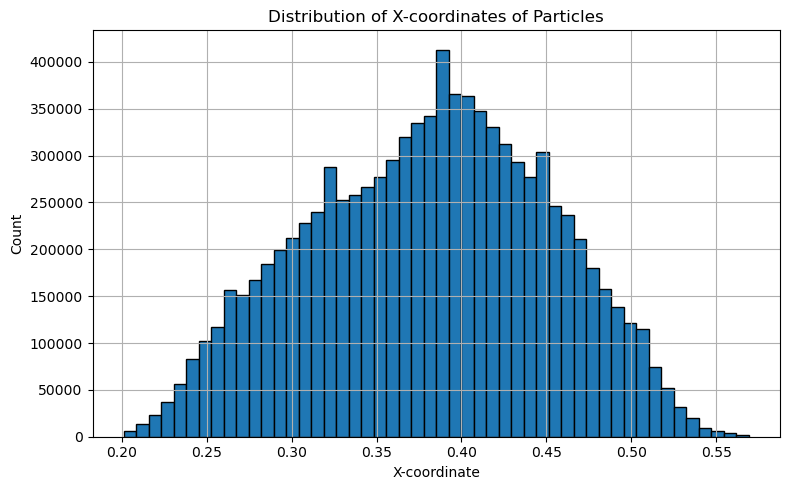

In [12]:
x_coords = particles[:, 0].cpu().numpy()  # Extract x-coordinates

plt.figure(figsize=(8, 5))
plt.hist(x_coords, bins=50, edgecolor='black')
plt.title("Distribution of X-coordinates of Particles")
plt.xlabel("X-coordinate")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
select1 = particles[:, 0] < 0.3
select2 = particles[:, 0] > 0.45
add_pre_particle_process1(mpm_solver, select = select1)
add_pre_particle_process2(mpm_solver, select = select2)

[functools.partial(<function add_pre_particle_process1.<locals>.my_deform at 0x7d93b5b74ee0>, start_time=0.0, end_time=999.0, select=tensor([ True,  True,  True,  ..., False, False, False], device='cuda:3'))]
[functools.partial(<function add_pre_particle_process1.<locals>.my_deform at 0x7d93b5b74ee0>, start_time=0.0, end_time=999.0, select=tensor([ True,  True,  True,  ..., False, False, False], device='cuda:3')), functools.partial(<function add_pre_particle_process2.<locals>.my_deform at 0x7d8dbe2a6160>, start_time=0.0, end_time=999.0, select=tensor([False, False, False,  ...,  True,  True,  True], device='cuda:3'))]


In [14]:
select_all = select1 | select2
select_show = select_all.clone()
color = torch.zeros(len(particles))
color[select1] = 0.5  
color[select2] = 0.9  
color = color.cpu().numpy()
mp.plot(v, c = color, shading={"wireframe": False})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.3851703…

In [15]:
list_gpu_tensors()

 Size (MB) |                Shape |                           Type |     Device
--------------------------------------------------------------------------------
    110.67 | torch.Size([9222132, 3]) |         <class 'torch.Tensor'> |     cuda:3
    110.67 | torch.Size([9222132, 3]) |         <class 'torch.Tensor'> |     cuda:3
    110.67 | torch.Size([9222132, 3]) |         <class 'torch.Tensor'> |     cuda:3
      9.22 | torch.Size([9222132]) |         <class 'torch.Tensor'> |     cuda:3
      9.22 | torch.Size([9222132]) |         <class 'torch.Tensor'> |     cuda:3
      9.22 | torch.Size([9222132]) |         <class 'torch.Tensor'> |     cuda:3
      9.22 | torch.Size([9222132]) |         <class 'torch.Tensor'> |     cuda:3
      0.19 | torch.Size([15625, 3]) |         <class 'torch.Tensor'> |     cuda:3
      0.19 | torch.Size([15625, 3]) |         <class 'torch.Tensor'> |     cuda:3
      0.06 |  torch.Size([15625]) |         <class 'torch.Tensor'> |     cuda:3
      0.00 |  torch

/home/cx2219/miniconda3/envs/mpmpytorch/lib/python3.9/site-packages/torch/__init__.py:1117: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
/tmp/ipykernel_1001240/2949170866.py:10: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):


In [16]:
# Initialize particle states
x = particles
v = torch.stack([torch.tensor(initial_velocity, device=device) for _ in range(n_particles)])
C = torch.zeros((n_particles, 3, 3), device=device)
F = torch.eye(3, device=device).unsqueeze(0).repeat(n_particles, 1, 1)


In [17]:
# Run simulation
frames = []
for frame in tqdm(range(num_frames), desc='Simulating'):
    frames.append(x.cpu().numpy())
    for step in tqdm(range(steps_per_frame), desc='Step'):
        # Update stress
        stress = elasticity(F)
        # Particle to grid, grid update, grid to particle
        x, v, C, F = mpm_solver(x, v, C, F, stress)
        # Plasticity correction
        F = plasticity(F)

Simulating:   0%|          | 0/50 [00:00<?, ?it/s]

Step:   0%|          | 0/10 [00:00<?, ?it/s]

Warp DeprecationWarning: the built-in `wp.matrix()` won't support taking column vectors as input in the future. Use `wp.matrix_from_rows()` or `wp.matrix_from_cols()` instead.
Module mpm_pytorch.constitutive_models.warp_svd.svd b8eca8e load on device 'cuda:3' took 370.20 ms  (compiled)


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.35 GiB. GPU 3 has a total capacity of 47.37 GiB of which 5.69 GiB is free. Including non-PyTorch memory, this process has 41.68 GiB memory in use. Of the allocated memory 32.20 GiB is allocated by PyTorch, and 8.99 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [18]:
list_gpu_tensors()

 Size (MB) |                Shape |                           Type |     Device
--------------------------------------------------------------------------------
   8963.91 | torch.Size([9222132, 27, 3, 3]) |         <class 'torch.Tensor'> |     cuda:3
   8963.91 | torch.Size([9222132, 27, 3, 3]) |         <class 'torch.Tensor'> |     cuda:3
   2987.97 | torch.Size([9222132, 27, 3]) |         <class 'torch.Tensor'> |     cuda:3
   2987.97 | torch.Size([9222132, 27, 3]) |         <class 'torch.Tensor'> |     cuda:3
   2987.97 | torch.Size([248997564, 3]) |         <class 'torch.Tensor'> |     cuda:3
   1991.98 | torch.Size([248997564]) |         <class 'torch.Tensor'> |     cuda:3
    995.99 | torch.Size([9222132, 27]) |         <class 'torch.Tensor'> |     cuda:3
    995.99 | torch.Size([9222132, 3, 3, 3]) |         <class 'torch.Tensor'> |     cuda:3
    995.99 | torch.Size([9222132, 27]) |         <class 'torch.Tensor'> |     cuda:3
    995.99 | torch.Size([248997564]) |         <clas

/home/cx2219/miniconda3/envs/mpmpytorch/lib/python3.9/site-packages/torch/__init__.py:1117: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
/tmp/ipykernel_1001240/2949170866.py:10: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):


In [ ]:
particles_show = x.clone()
v = particles_show.cpu().numpy()
mp.plot(v, c = color, shading={"wireframe": False})

In [ ]:
new_frames = frames[::sample_rate]

# Visualize
print(f'Rendering to {export_path}...')
visualize_frames(
    new_frames, 
    export_path=export_path, 
    size=[1, 1, 1], 
    c=color,
    sample_rate = sample_rate
)

# import messed up pc to voxel inside

In [ ]:

points_inside = particles_show.cpu().numpy()
indices = (points_inside * grid_res).astype(int)
indices = np.clip(indices, 0, grid_res - 1)  # make sure indices are valid

# Create occupancy grid
inside = np.zeros((grid_res, grid_res, grid_res), dtype=bool)
for i, j, k in indices:
    inside[i, j, k] = True

inside = inside.ravel(order='C')

In [ ]:
p = mp.plot(points_inside, shading={"wireframe": False})

# voxel to SDF

In [ ]:
# continuous
inside_volume = inside.reshape((grid_res, grid_res, grid_res))  # shape: (Z, Y, X)

outside_mask = ~inside_volume  # 0=inside, 1=outside

dist_out = ndimage.distance_transform_edt(outside_mask)

dist_in = ndimage.distance_transform_edt(inside_volume)

sdf_volume = dist_out - dist_in  # outside: positive, inside: negative

sdf_smoothed = gaussian_filter(sdf_volume, sigma=1.0)

sdf_volume = sdf_smoothed


# SDF to Surface Mesh

In [ ]:


verts, faces, normals, values = measure.marching_cubes(sdf_volume, level=0.0)

verts = verts[:, [2, 1, 0]]  # 把 zyx 转成 xyz

spacing = 1.0 / (sdf_volume.shape[0] - 1)
verts *= spacing  # 恢复真实坐标

mesh_surface = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)


In [ ]:

v = np.asarray(mesh_surface.vertices)
f = np.asarray(mesh_surface.faces)
n = np.asarray(mesh_surface.vertex_normals)

mp.plot(v, f, shading={"wireframe": False})


# Clean again

In [ ]:
components = mesh_surface.split(only_watertight=False)

# 统计数量
print(f"连通组件数量: {len(components)}")

largest = max(components, key=lambda m: len(m.faces))
mesh_clean = largest

# min_faces = 100000
# filtered = [comp for comp in components if len(comp.faces) >= min_faces]

# if len(filtered) > 0:
#     mesh_clean = trimesh.util.concatenate(filtered)
#     mesh_clean.export('cleaned_mesh.obj')
#     print(f"Keep {len(filtered)} component, output new mesh.")
# else:
#     print("All components have been filtered")


v = np.asarray(mesh_clean.vertices)
f = np.asarray(mesh_clean.faces)
n = np.asarray(mesh_clean.vertex_normals)

p = mp.plot(v, f)

mesh_surface = mesh_clean


# Surface Smoothing

In [ ]:
# 将 trimesh 转换为 open3d mesh
mesh_o3d = o3d.geometry.TriangleMesh(
    vertices=o3d.utility.Vector3dVector(mesh_surface.vertices),
    triangles=o3d.utility.Vector3iVector(mesh_surface.faces)
)

# 可选：计算法线（用于可视化）
mesh_o3d.compute_vertex_normals()

# 执行 Laplacian 平滑
smoothed = mesh_o3d.filter_smooth_laplacian(number_of_iterations=10)

# 可选：重新计算法线
smoothed.compute_vertex_normals()

# 如果你需要导出为 trimesh 继续处理：
smoothed_trimesh = trimesh.Trimesh(
    vertices=np.asarray(smoothed.vertices),
    faces=np.asarray(smoothed.triangles)
)

# ms = pymeshlab.MeshSet()
# ms.add_mesh(pymeshlab.Mesh(mesh_surface.vertices, mesh_surface.faces))


# ms.apply_coord_taubin_smoothing(stepsmoothnum=10, lambda_=0.5, mu=-0.53)


# smoothed_mesh = ms.current_mesh()
# smoothed_trimesh = trimesh.Trimesh(
#     vertices=smoothed_mesh.vertex_matrix(),
#     faces=smoothed_mesh.face_matrix()
# )

In [ ]:
v = np.asarray(smoothed.vertices)
f = np.asarray(smoothed.triangles)
# v = np.asarray(smoothed_mesh.vertex_matrix())
# f = np.asarray(smoothed_mesh.face_matrix())

mp.plot(v, f, shading={"wireframe": False})
